<a href="https://colab.research.google.com/github/Gooogr/YOLO_Toolkit/blob/master/Convert_YOLO2TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import fileinput
import urllib.request
import cv2
from google.colab.patches import cv2_imshow

In [2]:
# Enable GPU
# Check what we get: K80, P100, K4 or T4.
! nvidia-smi

Thu Sep 10 12:16:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
IS_TINY = True                               # Use YOLOv4 or Tiny YOLOv4 
WEIGHT_PATH = None                           # Specify url path to your weights. 
                                             # By default - example weights from project repository
CLASS_NAMES = ['Human face', 'Human hand']   # Specify your Imagenetv4 labels. By default - example 
                                             # labels corresponded to example weights 
INPUT_SIZE = None                            # Specify, if you use custom image size during the training.
                                             # By default - 416 for Tiny YOLO and 608 for YOLO                                           

### Prepare converter and files

In [4]:
# Clone converter
! git clone https://github.com/hunglc007/tensorflow-yolov4-tflite

Cloning into 'tensorflow-yolov4-tflite'...
remote: Enumerating objects: 780, done.
remote: Total 780 (delta 0), reused 0 (delta 0), pack-reused 780
Receiving objects: 100% (780/780), 197.64 MiB | 23.53 MiB/s, done.
Resolving deltas: 100% (371/371), done.


https://github.com/hunglc007/tensorflow-yolov4-tflite -

https://www.youtube.com/watch?v=iPwepy-SVCQ
https://github.com/theAIGuysCode/tensorflow-yolov4-tflite

Download pre-trained YOLO weights

In [5]:
if WEIGHT_PATH is None:
    WEIGHT_PATH = 'https://github.com/Gooogr/YOLO_Toolkit/raw/master/sample_tiny_weights/yolov4-tiny-sample.weights'

In [6]:
! wget -O /content/tensorflow-yolov4-tflite/data/custom_yolo.weights $WEIGHT_PATH 

--2020-09-10 12:20:21--  https://github.com/Gooogr/YOLO_Toolkit/raw/master/sample_tiny_weights/yolov4-tiny-sample.weights
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/master/sample_tiny_weights/yolov4-tiny-sample.weights [following]
--2020-09-10 12:20:21--  https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/master/sample_tiny_weights/yolov4-tiny-sample.weights
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23530556 (22M) [application/octet-stream]
Saving to: ‘/content/tensorflow-yolov4-tflite/data/custom_yolo.weights’

/content/tensorflow 100%[===================>]  22.44M 

Create ```yolo.names``` file

In [8]:
with open('/content/tensorflow-yolov4-tflite/data/classes/custom.names', 'w') as f:
    for item in CLASS_NAMES:
        f.write("%s\n" % item)

In [9]:
! cat /content/tensorflow-yolov4-tflite/data/classes/custom.names

Human face
Human hand


Add new ```custom.names``` filepath to the ```core/config.py``` file

In [23]:
#From https://stackoverflow.com/a/20593644/11664121

filename = '/content/tensorflow-yolov4-tflite/core/config.py'
text_to_search = 'coco.names'
replacement_text = 'custom.names'

with fileinput.FileInput(filename, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(text_to_search, replacement_text), end='')

### Convertation

In [24]:
% cd /content/tensorflow-yolov4-tflite

/content/tensorflow-yolov4-tflite


In [29]:
if INPUT_SIZE is None:
    if IS_TINY:
        INPUT_SIZE = 416
    else:
        INPUT_SIZE = 608

Convert Darknet model into TensorFlow .pb format

In [30]:
%%capture
if IS_TINY:
    ! python save_model.py \
    --weights ./data/custom_yolo.weights \
    --output ./checkpoints \
    --input_size $INPUT_SIZE \
    --model yolov4 --tiny
else:
    ! python save_model.py \
    --weights ./data/custom_yolo.weights \
    --output ./checkpoints \
    --input_size $INPUT_SIZE \
    --model yolov4 

In [31]:
! ls /content/tensorflow-yolov4-tflite/checkpoints

assets	saved_model.pb	variables


Check convertation

In [39]:
def url_to_image(url, save_path=None):
    '''
    Download the image by url-link, convert it to a NumPy array. Encode it into OpenCV format.
    input:
        url - direct url link to image 
    output:
        OpenCV image.
    '''
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")

    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    if save_path is not None:
        cv2.imwrite(save_path, image)
    else:
        return image

In [40]:
group_of_people = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTpvoS_uA21r_FEhBBiRoBP1TBeu9Llrjdjdg&usqp=CAU'

In [41]:
url_to_image(group_of_people, save_path='/content/tensorflow-yolov4-tflite/data/sample_image.jpg')

In [ ]:
! python detect.py --weights ./checkpoints --size $INPUT_SIZE \
--model yolov4 \
--image ./data/sample_image.jpg  \
--tiny

In [ ]:
# predict_sample()

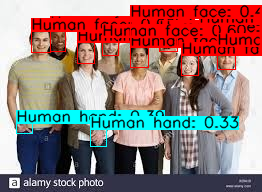

In [47]:
result_img = cv2.imread('/content/tensorflow-yolov4-tflite/result.png')
cv2_imshow(result_img)